# Part E: Debugging your SDL (MacOS version)

In this notebook, we have collected some scripts that help debug the SDL if something goes wrong.

Go to [sdl4kids.com](http://sdl4kids.com) for the Windows version.

If you have any questions, check out the [FAQ](https://sites.google.com/matterhorn.studio/sdl4kids/faq)!

In [13]:
import random
import numpy as np
import cv2

# Function to generate random color
def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return blue, green, red  # OpenCV uses BGR color format

# Function to calculate the error between two colors
def calculate_error(color1, color2):
    return np.sqrt((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2)


## (1) Problem: Your computer screens colors are different to what the microbit measures

The truth is, if you show the color red (255,0,0) on your screen, the microbit will measure something more like (180,50,50) as there will be background colors from your room intereferring.

The code below will run 255 experiments, where we test all colors from (0,0,0) to (255,0,0), i.e. making the screen more and more red. In the plot below, showcasing the error and the different measurements, you can see that despite making the screen all red, we still measure some blue and green. 

In [14]:
import serial
import pandas as pd

In [15]:
!ls /dev/cu.*

/dev/cu.Bluetooth-Incoming-Port /dev/cu.ZeitlersBoseQC35II
/dev/cu.RoastBeats              /dev/cu.usbmodem102


In [16]:
ser = serial.Serial()
ser = serial.Serial("/dev/cu.usbmodem102",115200, timeout=0.1)

In [17]:
import time
def characterise(wait=0.5):
    valid = False
    while not valid:
        try:
            ser.flushInput()
            ser.write(b",")
            serial_data = str(ser.readline().decode('utf8')).rstrip()
            rgb = tuple([int(value) for value in serial_data.split("-")])
            # Validate: Measurement needs three entries
            if len(rgb) != 3:
                print(f"Measurement did not containt 3 RGB values:{rgb}")
                raise Exception()
            # Validate: Measurements need to be between 0 and 255
            if sum([0 <= x <= 255 for x in rgb]) != 3:
                print(f"Measurement outside valid range [0,255]:{rgb}")
                raise Exception()
            valid = True
        except Exception as e:
            print(f"Measurement invalid, will try again (error: {str(e)})")
    print(f"New RGB Measurement: {rgb}")
    time.sleep(wait)
    return rgb

In [18]:
characterise()

New RGB Measurement: (90, 90, 76)


(90, 90, 76)

In [21]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (255,0,0)  # Goal color

# Main loop
max_iterations = 255  # Set the desired number of iterations

# Let us set up a data table to record the data more structured
samples = pd.DataFrame(columns=['R', 'G', 'B', 'error', 'ID'])

candidate_color = (0,0,0) # Initial color

for iteration in range(max_iterations):
    print(f"---Iteration {iteration}")
    candidate_color = (iteration, 0, 0)

    # STEP 1: Synthesis
    # Update the live image with the current color
    print(f"Synthesis:{candidate_color}")
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    rgb_measurement = characterise(wait=0.002)  
    print(f"Characterisation:{rgb_measurement}")
    #rgb_measurement = (rgb_measurement[0]+np.random.normal(1),rgb_measurement[1]+np.random.normal(1),rgb_measurement[2]+np.random.normal(1))
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)
    print(f"Error:{error}")

    # Add the sample to the data table
    new_sample = pd.DataFrame({"R":rgb_measurement[0], "G":rgb_measurement[1], "B":rgb_measurement[2], "ID":iteration, "error":error}, index=[iteration])
    samples = pd.concat([samples, new_sample], axis=0, ignore_index=True)

    #candidate = calculate_candidate(samples)
    #candidate_color = (candidate['R'], candidate['G'], candidate['B'])
    #print(f"Planning: Candidate:{candidate_color}")
    
    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = 50
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), tuple(reversed(goal_color)), -1)

    # Add text for the error
    error_text = f"Error: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    error_values = list(samples['error'].to_numpy())    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(1)  # Adjust the wait time (in milliseconds) as needed
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

---Iteration 0
Synthesis:(0, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 1
Synthesis:(1, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 2
Synthesis:(2, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 3
Synthesis:(3, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 4
Synthesis:(4, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 5
Synthesis:(5, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 6
Synthesis:(6, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 7
Synthesis:(7, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:202.7338156302495
---Iteration 8
S

Characterisation:(104, 102, 86)
Error:201.49689823915404
---Iteration 68
Synthesis:(68, 0, 0)
New RGB Measurement: (104, 102, 86)
Characterisation:(104, 102, 86)
Error:201.49689823915404
---Iteration 69
Synthesis:(69, 0, 0)
New RGB Measurement: (104, 102, 86)
Characterisation:(104, 102, 86)
Error:201.49689823915404
---Iteration 70
Synthesis:(70, 0, 0)
New RGB Measurement: (104, 102, 86)
Characterisation:(104, 102, 86)
Error:201.49689823915404
---Iteration 71
Synthesis:(71, 0, 0)
New RGB Measurement: (104, 102, 86)
Characterisation:(104, 102, 86)
Error:201.49689823915404
---Iteration 72
Synthesis:(72, 0, 0)
New RGB Measurement: (104, 102, 86)
Characterisation:(104, 102, 86)
Error:201.49689823915404
---Iteration 73
Synthesis:(73, 0, 0)
New RGB Measurement: (114, 93, 81)
Characterisation:(114, 93, 81)
Error:187.32591918898996
---Iteration 74
Synthesis:(74, 0, 0)
New RGB Measurement: (114, 93, 81)
Characterisation:(114, 93, 81)
Error:187.32591918898996
---Iteration 75
Synthesis:(75, 0, 0)


---Iteration 132
Synthesis:(132, 0, 0)
New RGB Measurement: (155, 67, 60)
Characterisation:(155, 67, 60)
Error:134.4953530795767
---Iteration 133
Synthesis:(133, 0, 0)
New RGB Measurement: (155, 67, 60)
Characterisation:(155, 67, 60)
Error:134.4953530795767
---Iteration 134
Synthesis:(134, 0, 0)
New RGB Measurement: (155, 67, 60)
Characterisation:(155, 67, 60)
Error:134.4953530795767
---Iteration 135
Synthesis:(135, 0, 0)
New RGB Measurement: (155, 67, 60)
Characterisation:(155, 67, 60)
Error:134.4953530795767
---Iteration 136
Synthesis:(136, 0, 0)
New RGB Measurement: (155, 67, 60)
Characterisation:(155, 67, 60)
Error:134.4953530795767
---Iteration 137
Synthesis:(137, 0, 0)
New RGB Measurement: (155, 67, 60)
Characterisation:(155, 67, 60)
Error:134.4953530795767
---Iteration 138
Synthesis:(138, 0, 0)
New RGB Measurement: (164, 61, 57)
Characterisation:(164, 61, 57)
Error:123.49493916756265
---Iteration 139
Synthesis:(139, 0, 0)
New RGB Measurement: (164, 61, 57)
Characterisation:(164,

New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 196
Synthesis:(196, 0, 0)
New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 197
Synthesis:(197, 0, 0)
New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 198
Synthesis:(198, 0, 0)
New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 199
Synthesis:(199, 0, 0)
New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 200
Synthesis:(200, 0, 0)
New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 201
Synthesis:(201, 0, 0)
New RGB Measurement: (176, 51, 47)
Characterisation:(176, 51, 47)
Error:105.12373661547615
---Iteration 202
Synthesis:(202, 0, 0)
New RGB Measurement: (181, 48, 44)
Characterisation:(181, 48, 44)
Error:98.56977224281286


-1

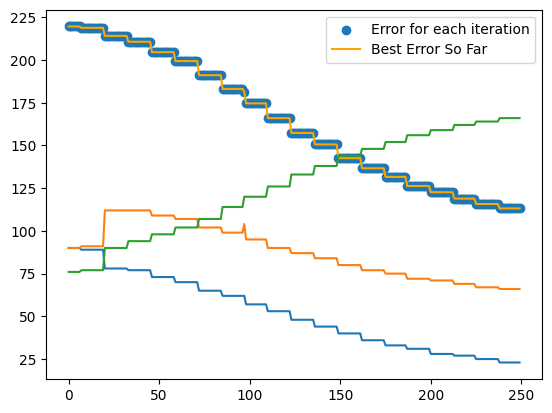

In [20]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.plot(samples['R'])
plt.plot(samples['G'])
plt.plot(samples['B'])
plt.legend()

In [61]:
samples

,R,G,B,error,ID
0,107,97,97,201.796928,0
1,107,97,97,201.796928,1
2,107,97,97,201.796928,2
3,107,97,97,201.796928,3
4,107,97,97,201.796928,4
...,...,...,...,...,...
245,28,219,32,317.039430,245
246,28,219,32,317.039430,246
247,28,219,32,317.039430,247
248,28,219,32,317.039430,248
